In [1]:
## Imports and get_param

import os
import sys

import h5py
import torch
from torch import optim
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join('..')))

from src.models.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from src.models.Watson_torch import Watson
from src.models.MixtureModel_torch import TorchMixtureModel
from src.models.HMM_torch import HiddenMarkovModel as HMM
from src.various.training import train_hmm

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

## Load data and get correct shape and dtype

In [2]:
synth_dataset = '../data/synthetic/HMMdata.h5'
dataf = h5py.File(synth_dataset, mode='r')
data = torch.tensor(np.array(dataf['X']))
data = torch.unsqueeze(torch.transpose(data,dim0=0,dim1=1),dim=0).float()
print(data.shape) #needs to be subjects, time, dims
print(data.dtype)
print(torch.norm(data,dim=2))

torch.Size([1, 2880, 3])
torch.float32
tensor([[1., 1., 1.,  ..., 1., 1., 1.]])


## Initialize model

In [3]:
model = HMM(num_states=2, emission_dist=ACG,observation_dim=3)
_ = get_param(model)

un_norm_priors
tensor([0.0245, 0.7697])
------------------------------
un_norm_Transition_matrix
tensor([[0.5557, 0.8359],
        [0.1512, 0.1691]])
------------------------------
emission_model_0
tensor([[   1.8984,  -16.0107,   -1.9029],
        [ -16.0107, 1280.1000,  -39.6540],
        [  -1.9029,  -39.6540,    7.6826]])
------------------------------
emission_model_1
tensor([[0.8263, 0.1592, 0.8476],
        [0.1592, 0.2948, 1.2112],
        [0.8476, 1.2112, 8.8422]])
------------------------------


## train model with diff learning rates, get best model 

In [10]:
hmm_eval_LR = np.arange(0.1, 1, 0.1)
#hmm_eval_LR = [0.01,0.1]
int_epoch = 100
acg_hmm_LR_results = np.zeros((len(hmm_eval_LR),int_epoch))
best_like = 400000.
for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    #model = HMM(num_states=2, observation_dim=3, emission_dist=ACG) #New init of model
    model = TorchMixtureModel(distribution_object=Watson,K=2, dist_dim=3) #New init of model
    Adam_optimizer = optim.Adam(model.parameters(), lr=LR)
    likehood = train_hmm(model, data=torch.squeeze(data), optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)
    acg_hmm_LR_results[idx] = likehood
    
    if likehood[-1] < best_like:
        best_model = model
        best_like = likehood[-1]
        best_idx = idx
        
    acg_hmm_LR_results[idx] = likehood

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## plot of learning rates

0
4128.44970703125


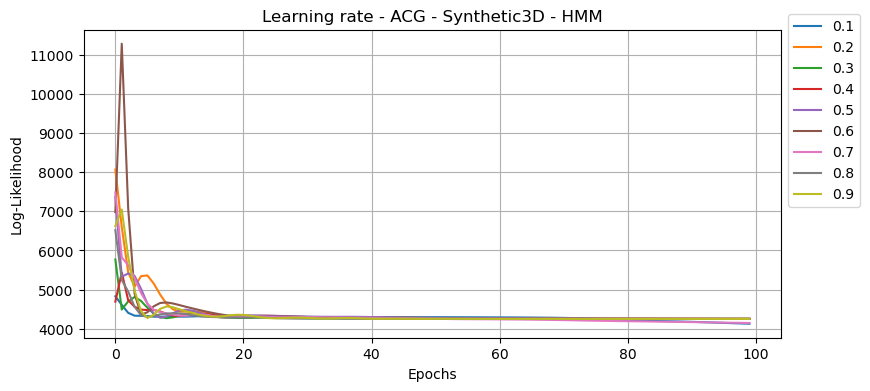

In [11]:
print(best_idx)
print(acg_hmm_LR_results[best_idx,-1])

plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(acg_hmm_LR_results.T)
plt.title('Learning rate - ACG - Synthetic3D - HMM')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=1, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

## extract parameters from the best model (should be pi=0.5)

In [12]:
acgbest_param = get_param(best_model)
#learned_sigma = torch.stack([acgbest_param[f'emission_model_{idx}'] for idx in range(best_model.N)])
#learned_pi = acgbest_param['un_norm_priors']
#learned_pi = torch.nn.functional.softmax(learned_pi,dim=0)
#print(learned_pi)

un_norm_pi
tensor([ 0.9407, -1.0398])
------------------------------
mix_comp_0
{'mu': tensor([0.0953, 0.6978, 0.7099]), 'kappa': tensor([5.0048])}
------------------------------
mix_comp_1
{'mu': tensor([0.5667, 0.5848, 0.5804]), 'kappa': tensor([9.9425])}
------------------------------


## Get emission probs and un viterbi decoding on best model

In [ ]:
best_paths, paths_probs, emission_probs = best_model.viterbi2(data)
np.savetxt('../data/synthetic/emissionprobs_ACG.csv', emission_probs, delimiter=',')
np.savetxt('../data/synthetic/best_path_ACG.csv', best_paths, delimiter=',')